In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("JupyterLabSparkApp") \
    .getOrCreate()


In [4]:
# Read the CSV into a Spark DataFrame
kindle_df = spark.read.option("header", True).option("inferSchema", True).csv("kindle_data-v2.csv")

# Check schema
kindle_df.printSchema()

# Preview the data
kindle_df.show(5)


root
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- soldBy: string (nullable = true)
 |-- imgUrl: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- price: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- isBestSeller: string (nullable = true)
 |-- isEditorsPick: string (nullable = true)
 |-- isGoodReadsChoice: string (nullable = true)
 |-- category_name: string (nullable = true)

+--------------------+-----------------+--------------------+--------------------+-----+-----+-----------+------------+-------------+-----------------+--------------------+
|               title|           author|              soldBy|              imgUrl|stars|price|category_id|isBestSeller|isEditorsPick|isGoodReadsChoice|       category_name|
+--------------------+-----------------+--------------------+--------------------+-----+-----+-----------+------------+-------------+-----------------+--------------------+
|Adult Children of...|Li

In [5]:
from pyspark.sql.functions import col, avg, row_number
from pyspark.sql.window import Window

# Step 1: Average star rating per book within each category
avg_ratings = kindle_df.groupBy("category_name", "title").agg(
    avg("stars").alias("avg_rating")
)

# Step 2: Use a window to rank books by rating within each category
window_spec = Window.partitionBy("category_name").orderBy(col("avg_rating").desc())

ranked_books = avg_ratings.withColumn("rank", row_number().over(window_spec))

# Step 3: Filter top 1 book per category
top_books_per_category = ranked_books.filter(col("rank") == 1).drop("rank")

top_books_per_category.show(10, truncate=False)


+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|category_name         |title                                                                                                                                                                                                   |avg_rating|
+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
| And More"            |"50 ""HOW TO"" books in 1: Personal Development                                                                                                                                                         |NULL      |
|1                     |"OM System ""Olympus"" OM-1:

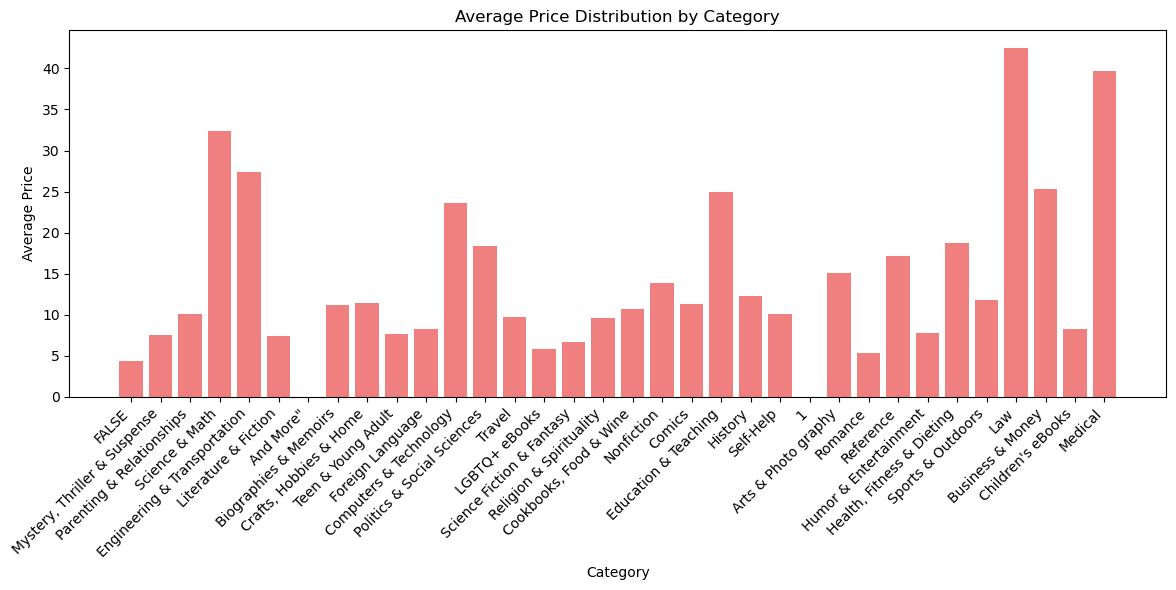

In [50]:
import matplotlib.pyplot as plt

# Convert price to numeric (float)
kindle_df = kindle_df.withColumn("price_numeric", col("price").cast("float"))

# Price distribution by category
price_by_category_pd = kindle_df.groupBy("category_name").agg(
    avg("price_numeric").alias("avg_price"),
    max("price_numeric").alias("max_price"),
    min("price_numeric").alias("min_price")
).toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(price_by_category_pd['category_name'], price_by_category_pd['avg_price'], color='lightcoral')
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.title('Average Price Distribution by Category')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [8]:
from pyspark.sql.functions import count

# Step 4: Aggregate total ratings per book
most_reviewed_books = kindle_df.groupBy("title", "author").agg(
    count("stars").alias("total_reviews")
).orderBy(col("total_reviews").desc())

# Display top 10
most_reviewed_books.show(10, truncate=False)


+------------------------------------------------------------------------+----------------+-------------+
|title                                                                   |author          |total_reviews|
+------------------------------------------------------------------------+----------------+-------------+
|The Richest Man in Babylon                                              |George S. Clason|5            |
|Meditations                                                             |Marcus Aurelius |4            |
|Legal and Ethical Issues for Health Professionals                       |George D. Pozgar|3            |
|Automotive Technology: A Systems Approach                               |Jack Erjavec    |3            |
|Wuthering Heights                                                       |Emily Brontë    |3            |
|Exploring Psychology                                                    |David G. Myers  |3            |
|Advanced Practice Nursing: Essential Knowledg

In [10]:
from pyspark.sql.functions import col

# Step 6: Find books with the highest price
most_expensive_books = kindle_df.withColumn(
    "price_float", col("price").cast("float")
).orderBy(col("price_float").desc())

# Display top 10
most_expensive_books.select("title", "author", "price").show(10, truncate=False)


+------------------------------------------------------------------------------------------------+--------------------------+------+
|title                                                                                           |author                    |price |
+------------------------------------------------------------------------------------------------+--------------------------+------+
|Drugs in Litigation: Damage Awards Involving Prescription and Nonprescription Drugs 2023 Edition|LexisNexis Editorial Staff|682   |
|Broker-Dealer Regulation                                                                        |Clifford E. Kirsch        |662   |
|Youmans and Winn Neurological Surgery E-Book: 4 - Volume Set                                    |H. Richard Winn           |636.99|
|How to Write a Patent Application                                                               |Jeffrey G. Sheldon        |629   |
|The Collected Works of C. G. Jung: Revised and Expanded Complete Dig

In [14]:
# Step 7: Books that are Best Sellers
best_seller_books = kindle_df.filter(col("isBestSeller") == "TRUE")

# Display top 10 Best Seller books
best_seller_books.select("title", "author", "category_name", "price").show(10, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------------------+-----+
|title                                                                                                                                               |author             |category_name            |price|
+----------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------------------+-----+
|Adult Children of Emotionally Immature Parents: How to Heal from Distant, Rejecting, or Self-Involved Parents                                       |Lindsay C. Gibson  |Parenting & Relationships|9.99 |
|Expecting Better: Why the Conventional Pregnancy Wisdom Is Wrong--and What You Really Need to Know (The ParentData Series Book 1)                   |Emily Oster        |Parenting & Relati

In [15]:
# Step 8: Average rating per category
category_avg_rating = kindle_df.groupBy("category_name").agg(
    avg("stars").cast("float").alias("avg_category_rating")
).orderBy(col("avg_category_rating").desc())

category_avg_rating.show(10, truncate=False)


+-------------------------+-------------------+
|category_name            |avg_category_rating|
+-------------------------+-------------------+
|Children's eBooks        |4.6325383          |
|Religion & Spirituality  |4.625639           |
|Comics                   |4.5792885          |
|Nonfiction               |4.558817           |
|Science Fiction & Fantasy|4.535219           |
|Self-Help                |4.5286083          |
|Teen & Young Adult       |4.525061           |
|Health, Fitness & Dieting|4.5122476          |
|Romance                  |4.474526           |
|Literature & Fiction     |4.4706407          |
+-------------------------+-------------------+
only showing top 10 rows



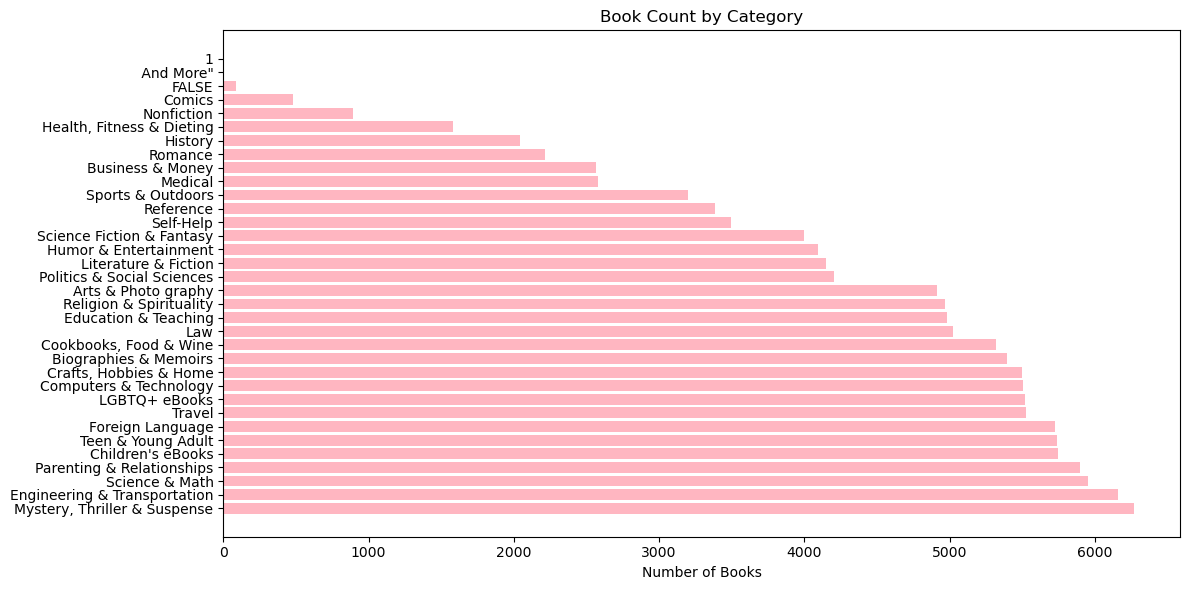

In [55]:
# Category-wise book count
category_book_count = kindle_df.groupBy("category_name").count().orderBy("count", ascending=False).toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(category_book_count['category_name'], category_book_count['count'], color='lightpink')
plt.xlabel('Number of Books')
plt.title('Book Count by Category')
plt.tight_layout()
plt.show()


In [16]:
from pyspark.sql.functions import col

# Step 8: Convert 'price' column to numeric (float) and analyze price distribution for best-sellers
best_seller_books_with_price = best_seller_books.withColumn(
    "price_numeric", col("price").cast("float")
).filter(col("price_numeric").isNotNull())  # Filter out invalid price values

# Show the price distribution
price_distribution = best_seller_books_with_price.groupBy("price_numeric").count().orderBy("price_numeric")
price_distribution.show(10, truncate=False)


+-------------+-----+
|price_numeric|count|
+-------------+-----+
|0.0          |92   |
|0.69         |1    |
|0.99         |119  |
|1.02         |1    |
|1.49         |3    |
|1.64         |1    |
|1.99         |109  |
|2.0          |2    |
|2.49         |10   |
|2.59         |1    |
+-------------+-----+
only showing top 10 rows



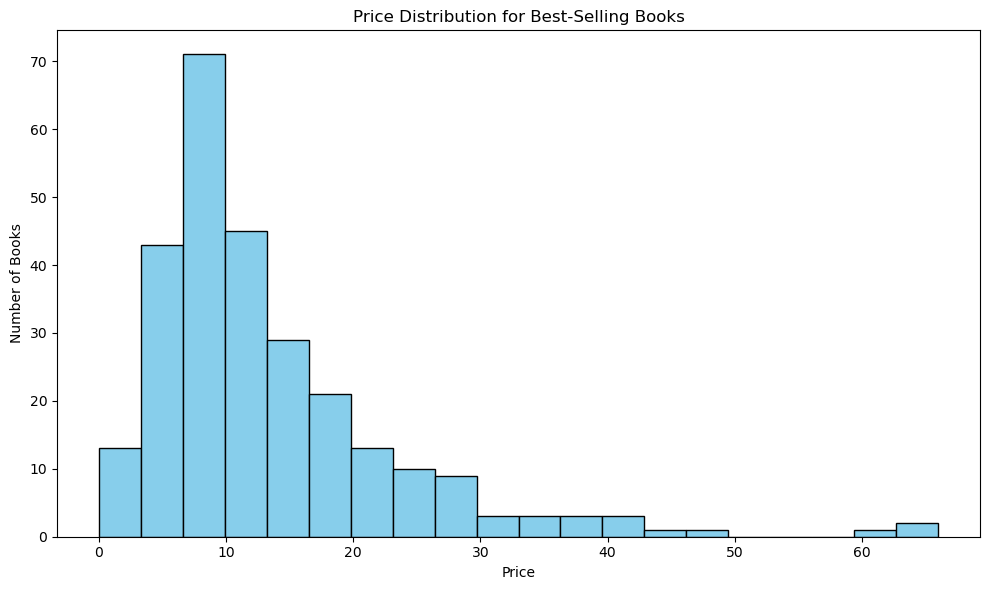

In [17]:
# Convert to Pandas for visualization
price_distribution_pd = price_distribution.toPandas()

# Visualize the price distribution using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(price_distribution_pd['price_numeric'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Number of Books')
plt.title('Price Distribution for Best-Selling Books')
plt.tight_layout()
plt.show()


In [18]:
# Step 10: Filter top-rated books
top_rated_books = kindle_df.groupBy("title", "author", "category_name").agg(
    avg("stars").alias("avg_rating")
).orderBy(col("avg_rating").desc())

# Join top-rated books with the original DataFrame to get the price
top_rated_books_with_price = top_rated_books.join(kindle_df, on=["title", "author", "category_name"])

# Convert price to numeric
top_rated_books_with_price = top_rated_books_with_price.withColumn(
    "price_numeric", col("price").cast("float")
).filter(col("price_numeric").isNotNull())

# Show top-rated books with price
top_rated_books_with_price.select("title", "author", "avg_rating", "price_numeric").show(10, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------+------------------------+----------+-------------+
|title                                                                                                                            |author                  |avg_rating|price_numeric|
+---------------------------------------------------------------------------------------------------------------------------------+------------------------+----------+-------------+
|Adult Children of Emotionally Immature Parents: How to Heal from Distant, Rejecting, or Self-Involved Parents                    |Lindsay C. Gibson       |4.8       |9.99         |
|From Strength to Strength: Finding Success, Happiness, and Deep Purpose in the Second Half of Life                               |Arthur C. Brooks        |4.4       |16.99        |
|Good Inside: A Guide to Becoming the Parent You Want to Be                               

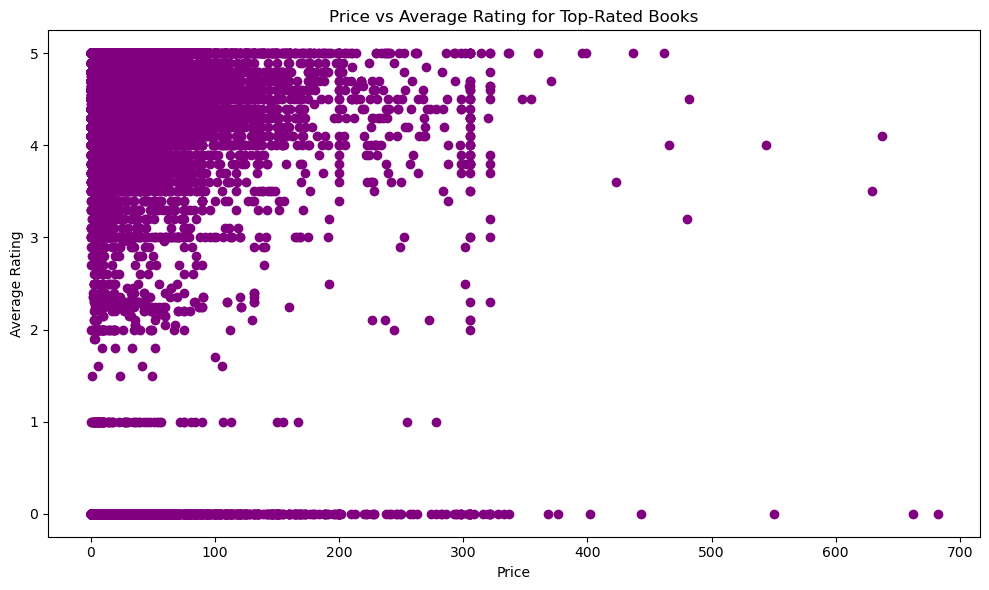

In [19]:
# Convert to Pandas for visualization
top_rated_books_with_price_pd = top_rated_books_with_price.toPandas()

# Visualize Price vs Rating
plt.figure(figsize=(10, 6))
plt.scatter(top_rated_books_with_price_pd['price_numeric'], top_rated_books_with_price_pd['avg_rating'], color='purple')
plt.xlabel('Price')
plt.ylabel('Average Rating')
plt.title('Price vs Average Rating for Top-Rated Books')
plt.tight_layout()
plt.show()


In [20]:
# Step 12: Count best-selling books per author
best_selling_authors = best_seller_books.groupBy("author").count().orderBy(col("count").desc())

# Show top 10 authors with most best-sellers
best_selling_authors.show(10, truncate=False)


+-------------------+-----+
|author             |count|
+-------------------+-----+
|J.K. Rowling       |16   |
|DK                 |10   |
|NULL               |8    |
|Paul Levine        |7    |
|Freida McFadden    |7    |
|Captivating History|7    |
|Paige Dearth       |6    |
|C.W. Farnsworth    |6    |
|Explore ToWin      |6    |
|William Bernhardt  |5    |
+-------------------+-----+
only showing top 10 rows



In [23]:
from pyspark.sql.functions import col, avg, max, min

# Step 13: Price distribution across categories
price_by_category = kindle_df.withColumn("price_numeric", col("price").cast("float")) \
    .groupBy("category_name").agg(
        avg("price_numeric").alias("avg_price"),
        max("price_numeric").alias("max_price"),
        min("price_numeric").alias("min_price")
    ).orderBy(col("avg_price").desc())

price_by_category.show(10, truncate=False)


+----------------------------+------------------+---------+---------+
|category_name               |avg_price         |max_price|min_price|
+----------------------------+------------------+---------+---------+
|Law                         |42.512807537293064|682.0    |0.0      |
|Medical                     |39.678849838760634|543.99   |0.0      |
|Science & Math              |32.41443793801286 |636.99   |0.0      |
|Engineering & Transportation|27.388250201693836|308.75   |0.0      |
|Business & Money            |25.35808859260317 |305.9    |0.0      |
|Education & Teaching        |24.899929679103032|200.0    |0.0      |
|Computers & Technology      |23.653229854933265|191.49   |0.0      |
|Health, Fitness & Dieting   |18.6861993333306  |549.99   |0.0      |
|Politics & Social Sciences  |18.321835329432858|322.0    |0.0      |
|Reference                   |17.12999691709634 |270.99   |0.0      |
+----------------------------+------------------+---------+---------+
only showing top 10 

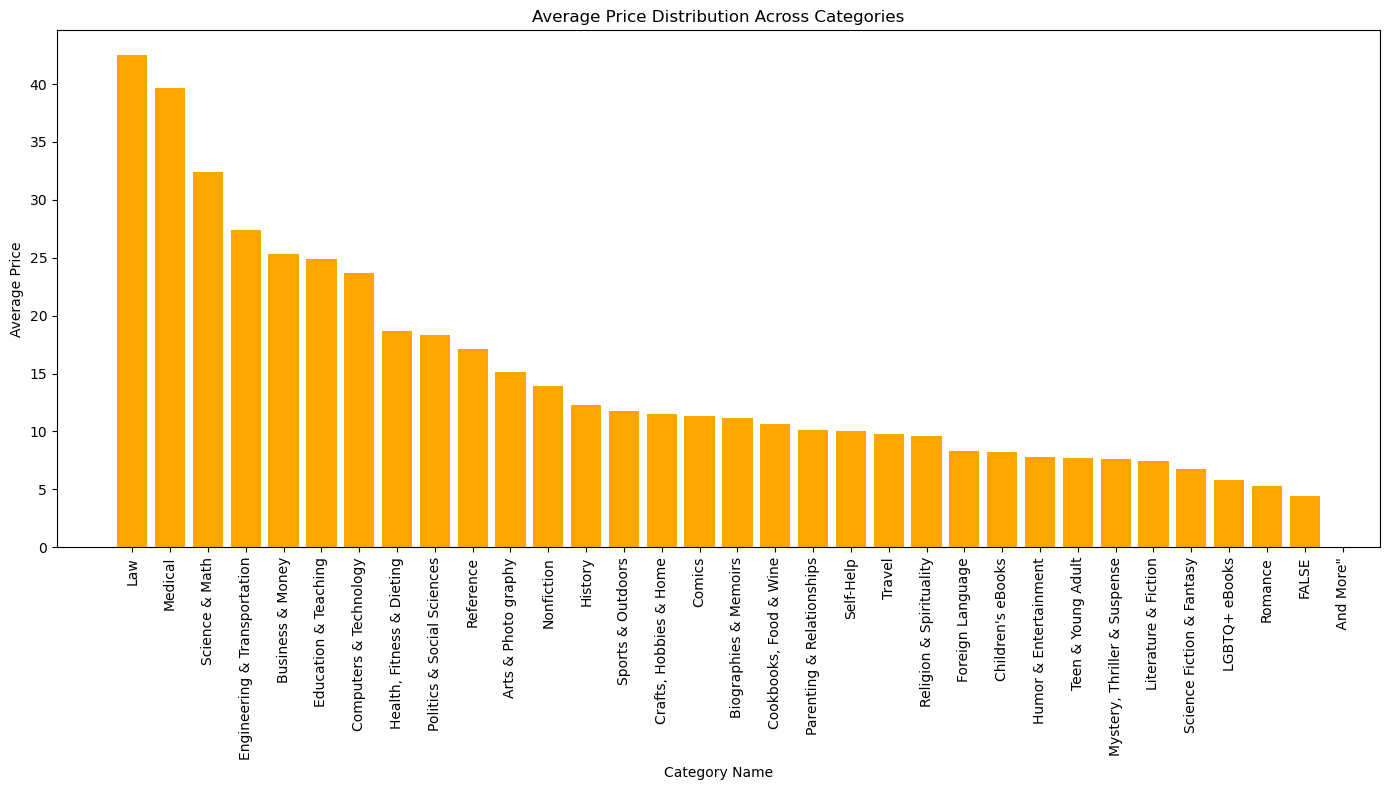

In [24]:
# Convert to Pandas for visualization
price_by_category_pd = price_by_category.toPandas()

# Plotting
plt.figure(figsize=(14, 8))
plt.bar(price_by_category_pd['category_name'], price_by_category_pd['avg_price'], color='orange')
plt.xlabel('Category Name')
plt.ylabel('Average Price')
plt.title('Average Price Distribution Across Categories')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [27]:
# Step 16: Best Seller vs Ratings Analysis
best_seller_vs_ratings = kindle_df.groupBy("isBestSeller").agg(
    avg("stars").alias("avg_rating"),
    count("title").alias("total_books")
).orderBy(col("avg_rating").desc())

# Show the analysis
best_seller_vs_ratings.show(2, truncate=False)


+------------+-----------------+-----------+
|isBestSeller|avg_rating       |total_books|
+------------+-----------------+-----------+
|TRUE        |4.491983878190774|2233       |
|FALSE       |4.402621960544419|130780     |
+------------+-----------------+-----------+
only showing top 2 rows



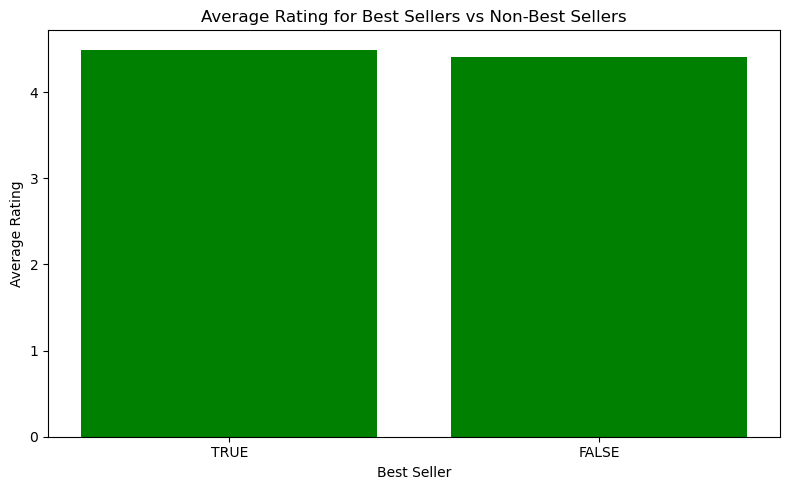

In [28]:
# Convert to Pandas for visualization
best_seller_vs_ratings_pd = best_seller_vs_ratings.toPandas()

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(best_seller_vs_ratings_pd['isBestSeller'], best_seller_vs_ratings_pd['avg_rating'], color='green')
plt.xlabel('Best Seller')
plt.ylabel('Average Rating')
plt.title('Average Rating for Best Sellers vs Non-Best Sellers')
plt.tight_layout()
plt.show()


In [32]:
from pyspark.sql.functions import avg, count

# Step 18: Author popularity based on the number of books and average rating
author_popularity = kindle_df.groupBy("author").agg(
    count("title").alias("num_books"),  # Counting the number of books for each author
    avg("stars").alias("avg_rating")   # Calculating the average rating for each author
).orderBy(col("num_books").desc())  # Sorting by number of books in descending order

# Show top 10 authors with the most books and their average rating
author_popularity.show(10, truncate=False)


+---------------------+---------+------------------+
|author               |num_books|avg_rating        |
+---------------------+---------+------------------+
|NULL                 |425      |4.368941176470588 |
|James Patterson      |212      |4.486320754716981 |
|DK Eyewitness        |163      |4.1748466257668735|
|DK                   |155      |4.67225806451613  |
|Captivating History  |120      |4.259166666666666 |
|Fodor's Travel Guides|115      |4.275652173913043 |
|Erin Hunter          |114      |4.785087719298248 |
|J.K. Rowling         |113      |4.743362831858409 |
|Hourly History       |103      |4.25631067961165  |
|Nora Roberts         |99       |4.546464646464645 |
+---------------------+---------+------------------+
only showing top 10 rows



In [31]:
kindle_df.columns


['title',
 'author',
 'soldBy',
 'imgUrl',
 'stars',
 'price',
 'category_id',
 'isBestSeller',
 'isEditorsPick',
 'isGoodReadsChoice',
 'category_name']

In [45]:
# Step 19: Bestseller analysis
bestseller_analysis = kindle_df.groupBy("isBestSeller").agg(
    avg("stars").alias("avg_rating"),
    avg("price").alias("avg_price")
).orderBy(col("avg_rating").desc())

# Show bestseller analysis
bestseller_analysis.show(2, truncate=False)


+------------+-----------------+------------------+
|isBestSeller|avg_rating       |avg_price         |
+------------+-----------------+------------------+
|TRUE        |4.491983878190774|7.68351992834748  |
|FALSE       |4.402621960544419|15.264303792626908|
+------------+-----------------+------------------+
only showing top 2 rows



In [37]:
# Step 20: Price distribution across stars
price_by_stars = kindle_df.withColumn("price_numeric", col("price").cast("float")) \
    .groupBy("stars").agg(
        avg("price_numeric").alias("avg_price"),
        max("price_numeric").alias("max_price"),
        min("price_numeric").alias("min_price")
    ).orderBy(col("avg_price").desc())

# Show price distribution by star ratings
price_by_stars.show(10, truncate=False)


+-----+------------------+---------+---------+
|stars|avg_price         |max_price|min_price|
+-----+------------------+---------+---------+
|1.7  |100.0             |100.0    |100.0    |
|1.6  |50.96999931335449 |105.59   |5.99     |
|2.9  |44.22735269630657 |301.58   |0.0      |
|3    |40.72724313864837 |322.0    |0.0      |
|2.5  |36.255908250808716|301.43   |2.99     |
|2.2  |34.896000719070436|79.8     |2.99     |
|1    |34.790843308690086|277.99   |0.0      |
|2.4  |34.49285725184849 |74.99    |8.0      |
|3.2  |34.4493547754903  |480.0    |0.99     |
|0    |34.41615911766057 |682.0    |0.0      |
+-----+------------------+---------+---------+
only showing top 10 rows



In [38]:
# Step 21: Books with highest and lowest prices
books_highest_price = kindle_df.withColumn("price_numeric", col("price").cast("float")) \
    .orderBy(col("price_numeric").desc())

books_lowest_price = kindle_df.withColumn("price_numeric", col("price").cast("float")) \
    .orderBy(col("price_numeric").asc())

# Show top 10 books with the highest prices
books_highest_price.show(10, truncate=False)

# Show top 10 books with the lowest prices
books_lowest_price.show(10, truncate=False)


+------------------------------------------------------------------------------------------------+--------------------------+-----------------------+--------------------------------------------------------------+-----+------+-----------+------------+-------------+-----------------+-------------------------+-------------+
|title                                                                                           |author                    |soldBy                 |imgUrl                                                        |stars|price |category_id|isBestSeller|isEditorsPick|isGoodReadsChoice|category_name            |price_numeric|
+------------------------------------------------------------------------------------------------+--------------------------+-----------------------+--------------------------------------------------------------+-----+------+-----------+------------+-------------+-----------------+-------------------------+-------------+
|Drugs in Litigation: Damage Aw

In [41]:
# Step 22: Best-selling books per category
best_selling_books_per_category = kindle_df.filter(col("isBestSeller") == "TRUE") \
    .groupBy("category_name", "title").agg(
        avg("stars").alias("avg_rating"),
        avg("price").alias("avg_price")
    ).orderBy(col("avg_rating").desc())

# Show top best-selling books for each category
best_selling_books_per_category.show(10, truncate=False)


+----------------------------+------------------------------------------------------------------------------------------------------------+----------+---------+
|category_name               |title                                                                                                       |avg_rating|avg_price|
+----------------------------+------------------------------------------------------------------------------------------------------------+----------+---------+
|Literature & Fiction        |Emerson Pass Historicals, Books 1-8: Complete Series                                                        |5.0       |1.99     |
|Religion & Spirituality     |If Only I'd Known: How to Outsmart Narcissists, Set Guilt-Free Boundaries, and Create Unshakeable Self-Worth|5.0       |0.99     |
|Literature & Fiction        |Losing Control : A Lesbian Romance (Dominion Book 1)                                                        |5.0       |4.99     |
|Engineering & Transportation|Your

In [43]:
# Step 24: Books with the best and worst ratings
best_rated_books = kindle_df.orderBy(col("stars").desc())
worst_rated_books = kindle_df.orderBy(col("stars").asc())

# Show top 10 best-rated books
best_rated_books.show(10, truncate=False)

# Show top 10 worst-rated books
worst_rated_books.show(10, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------+---------------------------------------+--------------------------------------------------------------+-----+-----------+------------+-------------+-----------------+-------------+
|title                                                                                                                                      |author                                                                       |soldBy                                              |imgUrl                                 |stars                                                         |price|category_id|isBestSeller|isEditorsPick|isGoodReadsChoice|category_name|
+---------------------------------------------------------------------------------------------

In [44]:
# Step 25: Number of books per author
books_per_author = kindle_df.groupBy("author").agg(
    count("title").alias("num_books")
).orderBy(col("num_books").desc())

# Show top 10 authors with the most books
books_per_author.show(10, truncate=False)


+---------------------+---------+
|author               |num_books|
+---------------------+---------+
|NULL                 |425      |
|James Patterson      |212      |
|DK Eyewitness        |163      |
|DK                   |155      |
|Captivating History  |120      |
|Fodor's Travel Guides|115      |
|Erin Hunter          |114      |
|J.K. Rowling         |113      |
|Hourly History       |103      |
|Nora Roberts         |99       |
+---------------------+---------+
only showing top 10 rows

